#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Differential Equations

We now consider the problem of computing $y(t)$ from an *ordinary differential equation* (ODE)

$$ y'(t) = f(t,y) $$

and initial condition $y(0)$.
In the following, $y$ may be a scalar or vector value.
For convenience of notation, we may suppress the time dependence by writing $y$ instead of $y(t)$.

### Second Order Equations

A second order system such as

$$ y'' = f(t, y, y') $$

may always be converted to a first order system by introducing a new variable

$$ \begin{bmatrix} y_0 \\ y_1 \end{bmatrix}' = \begin{bmatrix} y_1 \\ f(t, y_0, y_1) \end{bmatrix} . $$
Therefore, without loss of generality, we will focus on first order systems.

### Implicit formulations

We have chosen the explicit representation $y' = f(t,y)$, but it is more general to write $h(t,y,y') = 0$.
If $\partial h/\partial y'$ is singular, then this describes a *differential algebraic equation* (DAE).  DAE are more challenging to solve and beyond the scope of this course.

## Linear Equations

If $f(y,t)$ is a linear function of $y$ then we have a linear ODE
$$ y' = A(t) y + \text{source}(t) . $$
If $A(t)$ is independent of $t$ and $\text{source}(t) = 0$ then we have a linear, constant, autonomous ODE.

When $y$ is a scalar then $A = a$ is a scalar and the solution is
$$ y = y(0) e^{at} . $$

#### Question
What qualitative dynamics does this imply for
* $a > 0$?
* $a < 0$?
* $a$ imaginary?

#### Question
* What if $A$ is diagonal?
* What if $A = X \Lambda X^{-1}$?

#### Matrix exponential
The general solution can be written in terms of the matrix exponential.
$$ y(t) = e^{At} y(0) . $$
The matrix exponential is defined by its Taylor series
$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

## Forward Euler Method

The simplest method for solving $y'(t) = f(t,y)$ is
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$

In [81]:
%matplotlib notebook
import numpy
from matplotlib import pyplot

def ode_euler(f, y0, tfinal=1, h=0.1):
    y = numpy.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        y += h * f(t, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

tests = []

class cosine:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'cosine(k={:d})'.format(self.k)
    def f(self, t, y):
        return -self.k * (y - numpy.cos(t))
    def y(self, t, y0):
        k2p1 = self.k**2+1
        return (y0 - self.k**2/k2p1) * numpy.exp(-self.k*t) + self.k*(numpy.sin(t) + self.k*numpy.cos(t))/k2p1

tests.append(cosine(k=3))
tests.append(cosine(k=20))    

<IPython.core.display.Javascript object>


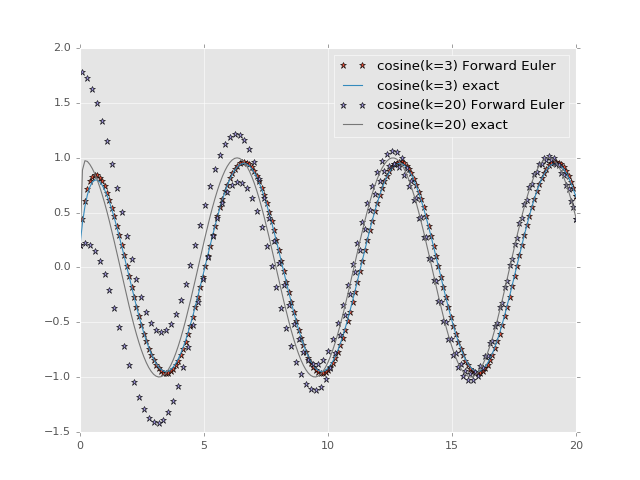

In [103]:
pyplot.style.use('ggplot')
pyplot.rcParams['figure.max_open_warning'] = False

y0 = numpy.array([.2])
pyplot.figure()
for test in tests:
    thist, yhist = ode_euler(test.f, y0, h=.099, tfinal=20)
    pyplot.plot(thist, yhist, '*', label=repr(test)+' Forward Euler')
    pyplot.plot(thist, test.y(thist, y0), label=repr(test)+' exact')
pyplot.legend(loc='upper right')

#### Question

* What happens when $h$ is increased?

<IPython.core.display.Javascript object>


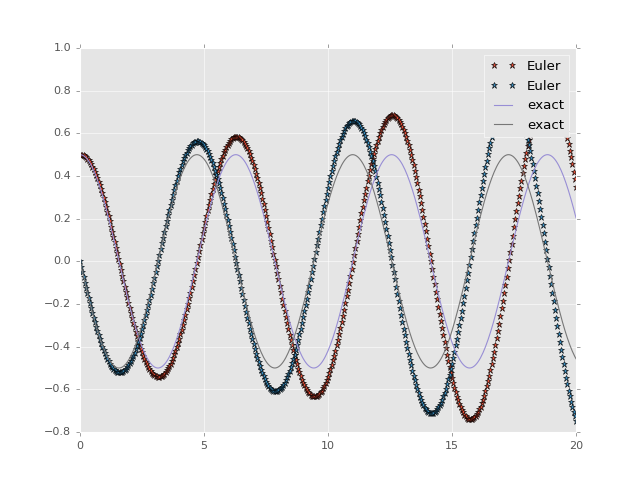

In [104]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X.dot(numpy.diag(numpy.exp(L))).dot(numpy.linalg.inv(X))

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, y):
        return self.A.dot(y)
    def y(self, t, y0):
        return [numpy.real(expm(self.A*s).dot(y0)) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))
y0 = numpy.array([.5, 0])
thist, yhist = ode_euler(test.f, y0, h=.05, tfinal=20)
pyplot.figure()
pyplot.plot(thist, yhist, '*', label='Euler')
pyplot.plot(thist, test.y(thist, y0), label='exact')
pyplot.legend(loc='upper right')

#### Questions
* Does shrinking $h$ make this more accurate?
* What if `tfinal` is extended?
* What are the eigenvalues of $A$?

#### Runge-Kutta 4
Let's try a different method.  (We'll look back at where this comes from later.)

<IPython.core.display.Javascript object>


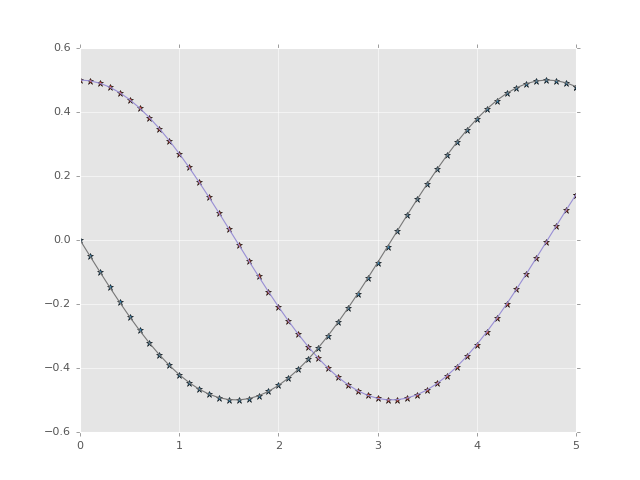

In [105]:
def ode_rk4(f, y0, tfinal=1, h=0.1):
    y = numpy.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        k1 = f(t, y)
        k2 = f(t+h/2, y + k1*h/2)
        k3 = f(t+h/2, y + k2*h/2)
        k4 = f(t+h, y + k3*h)
        y += h/6 * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

thist, yhist = ode_rk4(test.f, y0, h=.1, tfinal=5)
pyplot.figure()
pyplot.plot(thist, yhist, '*', label=repr(test)+' RK4')
pyplot.plot(thist, test.y(thist, y0), label=repr(test)+' exact')

### Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem
$$ y' = \lambda y $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ y \to y + h \lambda y = (1 + h \lambda) y =: R(h \lambda) y $$
where we have introduced the complex-valued function $R(z)$.

* When is this map stable?

<IPython.core.display.Javascript object>


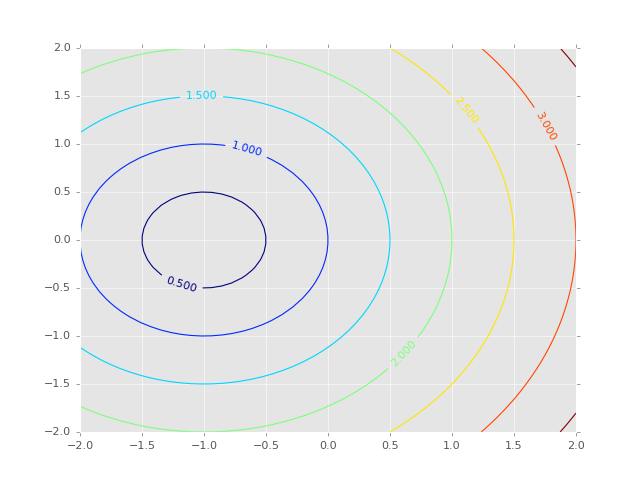

<a list of 6 text.Text objects>

In [22]:
pyplot.figure()
x = numpy.linspace(-2,2)
xx, yy = numpy.meshgrid(x, x)
zz = xx + 1j*yy
R = 1 + zz
C = pyplot.contour(xx, yy, numpy.abs(R))
pyplot.clabel(C)

Evidently the forward Euler method is stable if $h\lambda$ is in the unit circle centered at $z=-1$, but not stable otherwise.

#### Implicit methods
Recall that forward Euler is the step
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde y(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde y(h) = y(0) + h f(h, \tilde y(h)) . $$
This is a (generally) nonlinear equation for $\tilde y(h)$.
For the test equation $y' = \lambda y$, the backward Euler method is
$$ \tilde y(h) = y(0) + h \lambda \tilde y(h) $$
or
$$ \tilde y(h) = \frac{y(0)}{1 - h \lambda} . $$
Evidently the stability function is
$$ R(z) = \frac{1}{1-z} .$$

<IPython.core.display.Javascript object>


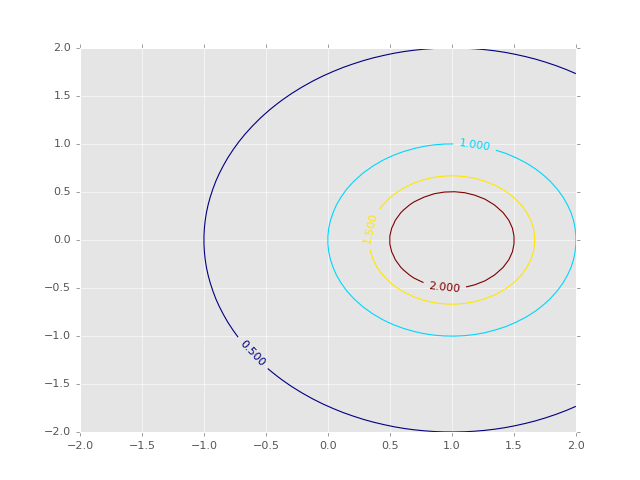

<a list of 4 text.Text objects>

In [26]:
pyplot.figure()
C = pyplot.contour(xx, yy, numpy.abs(1/(1-zz)), [.5, 1, 1.5, 2])
pyplot.clabel(C)

Evidently backward Euler is stable in the entire left half plane (where the exact solution is also stable) and also in some significant portions of the right half plane.  Let's test it on the oscillator problem.

<IPython.core.display.Javascript object>


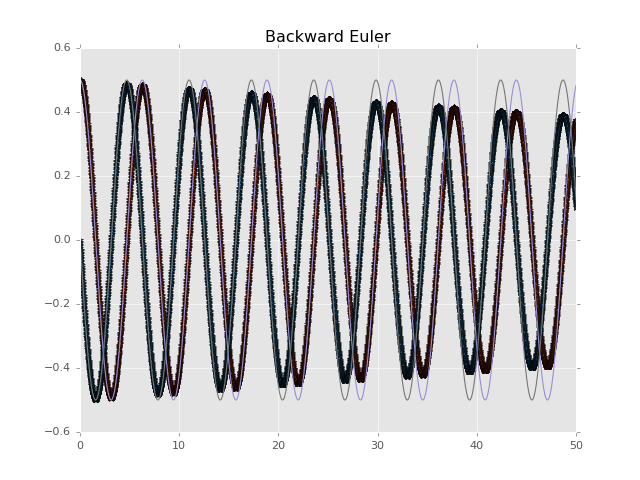

In [109]:
def solve_newtonfd(f, x0):
    def fdjacobian(x):
        J = numpy.eye(len(x),len(x))
        base = f(x)
        for col in J.T:
            col[:] = (f(x + 1e-8*col) - base) / 1e-8
        return J
    x = x0.copy()
    while True:
        res = f(x)
        if numpy.linalg.norm(res) < 1e-6:
            return x
        x -= numpy.linalg.solve(fdjacobian(x), res)

def ode_beuler(f, y0, tfinal=1, h=0.1):
    y = numpy.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve x = y + h f(x)
        def residual(x):
            return x - h * f(t+h, x) - y
        y = solve_newtonfd(residual, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

thist, yhist = ode_beuler(test.f, y0, h=.01, tfinal=50)
pyplot.figure()
pyplot.plot(thist, yhist, '*')
pyplot.plot(thist, test.y(thist, y0))
pyplot.title('Backward Euler')

#### Observations
* We need to solve a system of equations on each time step.
* The cost to solve the linear system is $O(n^3)$ for a system of $n$ equations.
* The Jacobian matrix is $n\times n$, so requires $n^2$ storage when everything else requires $O(n)$.
* I used finite differencing to compute the Jacobian, but many problems have efficient ways to compute an exact Jacobian (it just takes some programming).
* Backward Euler is stable (as predicted by theory), but not very accurate.
* What happens when you make the time step smaller or larger?

### Midpoint Method

What if instead of evaluating the function at the end of the time step, we evaluated in the middle of the time step using the average of the endpoint values.  After all, something similar improved accuracy for our numerical integration...

$$ \tilde y(h) = y(0) + h f\left(\frac h 2, \frac{\tilde y(h) + y(0)}{2} \right) $$

<IPython.core.display.Javascript object>


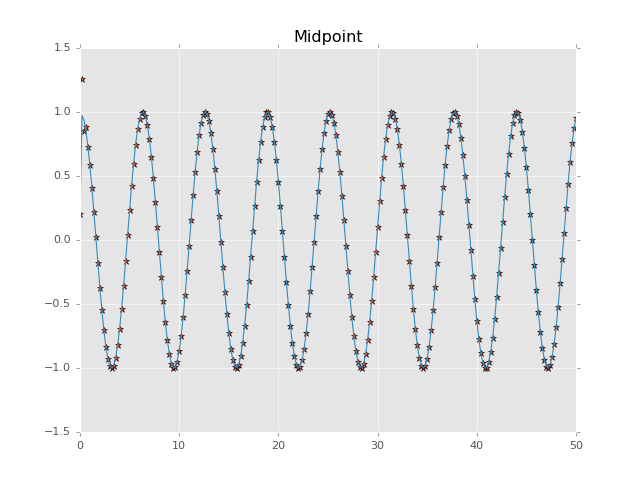

In [118]:
def ode_midpoint(f, y0, tfinal=1, h=0.1):
    y = y0.copy()
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve x = y + h f(x)
        def residual(x):
            return x - h * f(t+h/2, (x + y)/2) - y
        y = solve_newtonfd(residual, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return numpy.array(thist), numpy.array(yhist)

thist, yhist = ode_midpoint(test.f, y0, h=.2, tfinal=50)
pyplot.figure()
pyplot.plot(thist, yhist, '*')
pyplot.plot(thist, test.y(thist, y0))
pyplot.title('Midpoint')

<IPython.core.display.Javascript object>


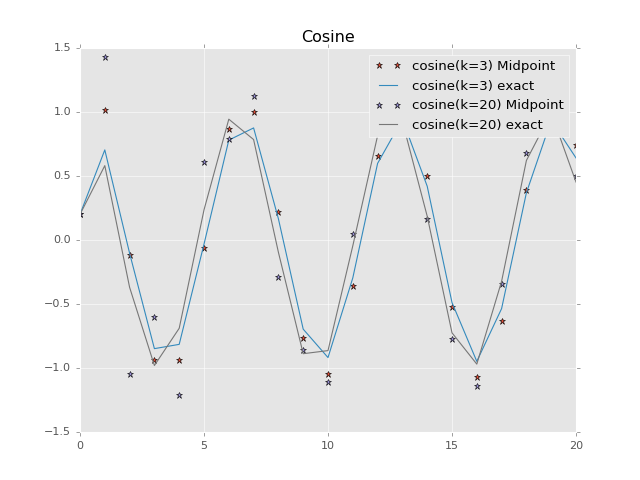

In [117]:
y0 = numpy.array([.2])
pyplot.figure()
for test in tests:
    thist, yhist = ode_midpoint(test.f, y0, h=1, tfinal=20)
    pyplot.plot(thist, yhist, '*', label=repr(test)+' Midpoint')
    pyplot.plot(thist, test.y(thist, y0), label=repr(test)+' exact')
pyplot.legend(loc='upper right')
pyplot.title('Cosine')

#### Observations/Questions

* This appears to be quite accurate.
* We still have to solve a system of equations on each time step.
* What happens when the step size changes?
* What is the stability function $R(z)$ for the midpoint rule?

### Runge-Kutta Methods

All of the methods we have seen thus far can be represented as Runge-Kutta methods, which can be arranged as a series of $s$ "stage" equations (possibly coupled) and a completion formula.

$$\begin{split}
Y_i = y(0) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
y(h) = y(0) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$

where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.
These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations).  We have seen forward Euler

$$ \left[ \begin{array}{c|cc}
0 & 0 & 0 \\
1 & 1 & 0 \\
\hline
& 1 & 0
\end{array} \right] ,$$
backward Euler
$$ \left[ \begin{array}{c|c}
1 & 1 \\
\hline
& 1
\end{array} \right] ,$$
and Midpoint
$$ \left[ \begin{array}{c|c}
\frac 1 2 & \frac 1 2 \\
\hline
& \frac 1 2
\end{array} \right], $$
and that explicit method we called RK4
$$ \left[ \begin{array}{c|cccc}
0 & 0 & 0 & 0 & 0 \\
\frac 1 2 & \frac 1 2 & 0 & 0 & 0 \\
\frac 1 2 & 0 & \frac 1 2 & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
\hline
& \frac 1 6 & \frac 1 3 & \frac 1 3 & \frac 1 6
\end{array} \right] . $$